<a id='beginning_CRVA'></a>
# Climate Risk and Vulnerability Analysis
This notebook helps you download and visualize climate data to perform Climate Risk and Vulnerability analyses
#### <span style="color: red;"> Before running the code the Kernel needs to be changed to "Python [conda env:geodata]" from the drop down menu in top!! </span> 

## Usage
This is how to use this script: 

1. [Define user input](#user_input)
2. Run wanted climate variables (links below)
3. [Export data](#Export)

## Input data
* [Shapefile with project location(s) as points or polygon](#load_shapefile)
* Shapefile with whole study area as polygon
* Coastal study area used for tsunami and earth -  XX DELETE????? 

## [Climate variables](#climate_variables)
* [Earthquakes](#earthquakes) 
* [Cyclone risk](#cyclone_risk)
* [Precipitation](#worldbank)
* [Temperature](#worldbank)
* [Wind speed](#wind_speed)- WORKING PROGRESS 
* [Tsunamis](#tsunami) - WORKING PROGRESS (server)
* [Landslides](#landslides)- WORKING PROGRESS (server)
    * [Rainfall triggered annual frequence](#) 
    * [Qualitative hazard assessment](#) 
* [Relative sea level rise](#relative_sea_level_rise) -WORKING PROGRESS 
* [Water availability](#water_availability) - WORKING PROGRESS
* [Floods](#floods) - WORKING PROGRESS (server)
    * [Fluvial](#floods) 
    * [Coastal](#coastal_flood)




## Contact

rapy@cowi.com


<a id='user_input'></a>
[Home](#beginning_CRVA)
## User inputs



In [22]:
#User inputs
import os.path

#project locations (shapefile with location of elements to evaluate)

cwd=os.getcwd()
main=os.path.abspath(os.path.join(cwd, os.pardir))
data_folder=os.path.join(main,'dataset') 
data_folder=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets'

#Shapefile wiht locations of interest
project_location_path=r'\\cowi.net\projects\A245000\A248363\CRVA\Datasets\timor\GIS\tim_loc.shp'#os.path.join(data_folder,'timor/GIS/timor_locPoints.shp')
#study boundary 
study_area_path=os.path.join(data_folder,'timor','GIS/boundaries.shp')
#Sea_area -- different study boundary, to be used for assessment along coastlines
sea_area_path=os.path.join(data_folder,'mozambique','sea_area.shp')
#area_square_path=os.path.join(data_folder,'timor','timor_leste.shp')

project_id='Name' #name of column used as id

out_path= os.path.join(data_folder,'outputs')

bCRS='EPSG:4326' #projection CRS (default = 'EPSG:4326')

#buffer for climate/grid variables
buffer=10000 #buffer in meters, 0 = no buffer is computed

mCRS='EPSG:32737' #metric CRS for buffer in meters 


[Home](#beginning_CRVA)
## Import python packages

In [23]:
#Import python packages
from rasterstats import zonal_stats
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import rioxarray #used when calling ncdata.rio.write_crs
import xarray as xr
import os
import os.path
import matplotlib.pyplot as plt
import netCDF4 as nc#not directly used but needs to be imported for some nc4 files manipulations, use for nc files
from netCDF4 import Dataset

import numpy as np
import warnings
warnings.filterwarnings('ignore') # to ignore the warnings

from geopandas import GeoDataFrame
from shapely.geometry import Point
from matplotlib.lines import Line2D

#from quicktool_functions import read_cckp_ncdata
#from quicktool_functions import get_cckp_file_name 

def read_cckp_ncdata(nc_path,output='tempfile.tif'):
    with rioxarray.open_rasterio(nc_path,decode_times=False)[0] as ncdata:
        ncdata.rio.write_crs('EPSG:4326', inplace=True)
        ncdata=ncdata.isel(time=0)
        ncdata.rio.to_raster(output)
        ncdata.close()
        
       # output=output #here
   # else: 
      #  print(nc_path,"not found") # in this case, the data printed in the table will apply to the previous print.. 
       # output=0 #here
    return output       

#def read nc files (copernicus)
#reads data from CMIP6 Copernicus, nc files
#assigns projection and exports to tif since zonal_stats seems to have issues with it otherwise (not ideal solution)
def read_nc_data(nc_path,stats,output='tempfile.tif'):
    with rioxarray.open_rasterio(nc_path,decode_times=False)[3] as ncdata:
        # calculate statistiques for each variable
        if stats == 'mean':
            ncdata=ncdata.mean(dim='time')
        elif stats == 'median':
            ncdata=ncdata.median(dim='time')
        elif stats == 'p10':
            ncdata=ncdata.quantile(0.1, dim='time')
        elif stats == 'p90':
            ncdata=ncdata.quantile(0.9, dim='time')
        
        ncdata.rio.write_crs('EPSG:4326', inplace=True)
        ncdata.rio.to_raster(output)
    return output       


<a id='load_shapefile'></a>
[Home](#beginning_CRVA)
## Load shapefiles and plot

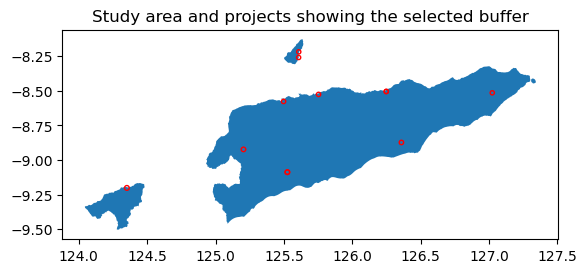

In [24]:
#load shapefiles
projects = gpd.read_file(project_location_path).to_crs(bCRS)
study_area = gpd.read_file(study_area_path).to_crs(bCRS)
#area_square=gpd.read_file(area_square_path)
sea_area = gpd.read_file(sea_area_path).to_crs(bCRS)

#Calculate buffer around points/shape
if buffer != 0:
    projects_buf=projects.to_crs(mCRS) #project to crs with metric units to get buffer in meters
    projects_buf['geometry']=projects.to_crs(mCRS).buffer(buffer)#assign the buffer as the new geometry - 
    projects_buf=projects_buf.to_crs(bCRS) #project back to orginal crs

    
#plot shapefiles
fig, ax = plt.subplots()
study_area.plot(ax=ax,)
#projects.plot(ax=ax,color='Black')
projects_buf.plot(ax=ax,edgecolor="red", facecolor="none") 
ax.set_title('Study area and projects showing the selected buffer')

#show table
projects[[project_id]]

#create output directory
if not os.path.isdir('outputs'):
    os.mkdir('outputs') 


<a id='earthquakes'></a>
[Home](#beginning_CRVA)
## Earthquakes - Land
source: https://wesr.unepgrid.ch/?project=MX-XVK-HPH-OGN-HVE-GGN&language=en&theme=color_light

GAR atlas: fully probabilistic seismic hazard analysis at global level was developed by CIMNE and INGENIAR Ltda. This hazard model is a continuation and improvement of the one developed in the framework of GAR13 where a set of tectonic provinces were identified and characterized by means of a set of parameters that describe the future seismic activity on each of them based on historical records together with relationships to obtained hazard intensities as a function of magnitude and distance. The hazard analysis was performed using the program CRISIS2014, a state-of-the-art tool for these kinds of tasks and widely known and acknowledged by experts in the field across the world. The chosen hazard intensity measure for this case was spectral acceleration and to guarantee a good connection between the hazard and the exposure characteristics, results for several ordinates between 0.0 and 2.3 seconds were computed. More detail about the probabilistic seismic hazard analysis can be found in Cardona et al. (2015).

#### Variables 
Peak ground acceleration (cm/s2) within the chosen period of years: 250 , 475, 975 ,1500, 2475 

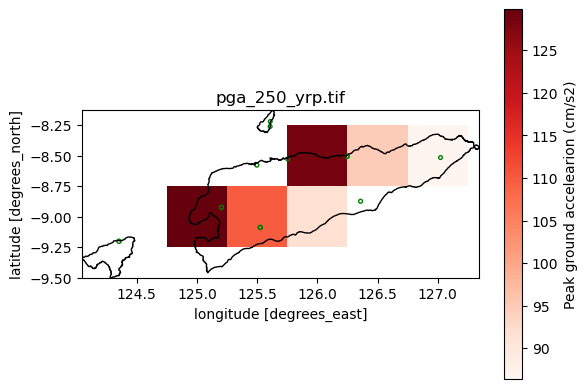

In [25]:
var='250' # '250' , '475', '975' ,'1500' , '2475'

filename='pga_'+var+'_yrp.tif'
projects_comb = gpd.read_file(project_location_path).to_crs(bCRS) #overview apart from wb data
earthquakes_path=os.path.join(data_folder,'earthquakes',filename) 

#spatial stats
projects_comb['earthquakes_'+filename]=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=earthquakes_path, 
                                                            all_touched=True, stats='max'))
#show table
projects_comb[[project_id,'earthquakes_'+filename]].head()

xlim = ([study_area.total_bounds[0],  study_area.total_bounds[2]])
ylim = ([study_area.total_bounds[1],  study_area.total_bounds[3]])

#plot earthquakes
fig, ax = plt.subplots()
earthquakes = rioxarray.open_rasterio(earthquakes_path) 
nodata = rasterio.open(earthquakes_path).nodata

earthquakes_clip = earthquakes.rio.clip(study_area.geometry, study_area.crs, drop=True)
earthquakes.close()
earthquakes_clip=earthquakes_clip.where(earthquakes_clip != nodata) # if to remove nan-values

earthquakes_clip.plot(ax=ax,  cmap='Reds',cbar_kwargs={'label':'Peak ground accelearion (cm/s2)'},xlim=(xlim),ylim=(ylim))
points=projects_buf.plot(ax=ax,edgecolor='green',facecolor='none') 
study_area.plot(ax=ax,edgecolor="black", facecolor="none")
ax.set_title(filename)

#close
earthquakes_clip.close()
fig.savefig('earthquakes_timor.svg', bbox_inches='tight')


<a id='cyclone_risk'></a>
[Home](#beginning_CRVA)
## Cyclones
data source: https://wesr.unepgrid.ch/?project=MX-XVK-HPH-OGN-HVE-GGN&language=en UNEP-GRID, 

cyclone risk level from 1 (low) to 5 (extreme)

NameError: name 'area_square' is not defined

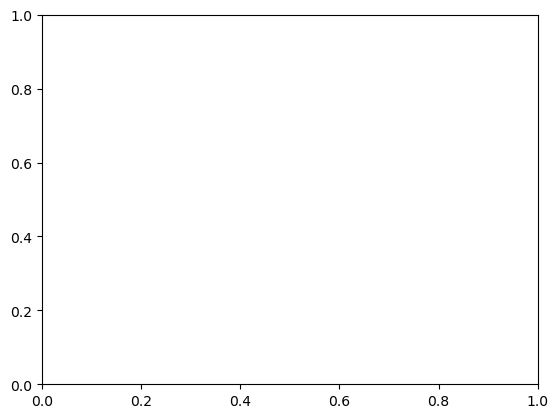

In [26]:
#cyclone data path
cyclone_path=os.path.join(data_folder,'cyclones/unep_grid/cy_risk.tif')
 
# \\COWI.net\projects\A245000\A248363\CRVA\Datasets\cyclones\unep_grid
#spatial stats
projects['cyclone_risk']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=cyclone_path, all_touched=True, stats='max'))

#show table
projects[[project_id,'cyclone_risk']].head()

#plot
fig, ax = plt.subplots()
cyclone = rioxarray.open_rasterio(cyclone_path)
cyclone_clip = cyclone.rio.clip(area_square.geometry, area_square.crs, drop=True)
nodata = rasterio.open(cyclone_path).nodata
cyclone_clip=cyclone_clip.where(cyclone_clip != nodata) 

cyclone_clip.plot(ax=ax,cmap=plt.cm.get_cmap('Reds',4),cbar_kwargs={'label':'Risk level','ticks':[0,1,2,3,4,5]})  #(ax=ax,vmin=0,vmax=20,cmap='Blues',cbar_kwargs={'label':'Water depth (m)'})
#projects.plot(ax=ax) # plot the projects on the map
projects_buf.plot(ax=ax,edgecolor="red", facecolor="none") 
study_area.plot(ax=ax,edgecolor='black',facecolor='none')
#ax.set_title('Floods extent with a\nreturn period of 100 years') # set a title to the image


plt.title('Cyclone risk level') # title of the graph

#close
cyclone_clip.close()
cyclone.close()

<a id='worldbank'></a>
[Home](#beginning_CRVA)
## World Bank Climate knowledge portal, Precipitation and Temperature - Atmosphere
Data source: https://climateknowledgeportal.worldbank.org/download-data

Choose variables by commenting, uncommenting variables in the code below

### Precipitation 

#### Incremental rainfall change 
* yearly average precipitation: pe annual mean
* seasonal average precipitation: pr seasonal mean

#### Extreme rainfall change  
* Average of the largest daily precipitation amount: rx1day
* Average of the largest 5-day consecutive precipitation amount: rx5day
* Return period of current 50 and 100 year 1 day event: frp50yr and frp100yr  

### Temperature
#### Incremental air temperature change
* Yearly mean temperature (average): tas

#### Extreme temperature increase 
* Annual number of hot days >40 degrees C (average): hd40
* Number of hot days >35 degrees C (average): hd35 
* Maximum of daily max-temperature (per year): txx 
* Average of maximum temperature: tasmax 

### Variables 
* Anomaly or climatology; anomaly is based on reference period 1995-2914
* periods: 2020-2039 and 2040-3059 
* ssps: ssp1.19, ssp1.26, ssp2.45, ssp3.70, ssp5.85
* gcms: median, p10, or p90 pecentile of ensemble models


In [21]:
#Read downloaded precipitation and temperature data
#Choolse variables
periods_future=['2020-2039','2040-2059'] #['2020-2039','2040-2059']
periods_frp=['2010-2039','2035-2064'] #['2010-2039','2035-2064']
ssps=['ssp245','ssp370'] #['ssp119','ssp126','ssp245','ssp370','ssp585']
gcms=['median','p10','p90'] #['median','p10','p90']

variables= {
    #Temperature
        #era/cru
            'climatology-hd35-annual-mean_era':{'periods':['1991-2020']},
           # 'climatology-hd40-annual-mean_era':{'periods':['1991-2020']},
          #  'climatology-tasmax-annual-mean_era':{'periods':['1991-2020']}, 
          #  'climatology-tas-annual-mean_era':{'periods':['1991-2020']},
           # 'climatology-tasmax-annual-mean_cru':{'perio
          #  'climatology-hd40':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
            'anomaly-hd40':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
          #  'anomaly-hd35':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
          #  'anomaly-tasmax':{'periods':periods_future,'ssps':ssps,'gcms':gcms}, 
          #  'anomaly-txx':{'periods':periods_future,'ssps':ssps,'gcms':gcms}, #txx=maximum of daily max temperature
           # 'climatology-txx':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
            #'anomaly-tas':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
          #  'climatology-tas':{'periods':periods_future,'ssps':ssps,'gcms':gcms}, #data not downloaded 
    #Precipitation
       #era/cru
         #   'climatology-r50mm-annual-mean_era_annual':{'periods':['1991-2020']},
         #   'climatology-rx1day-monthly-mean_era_monthly':{'periods':['1991-2020']},
         #   'climatology-rx1day-annual-mean_era_annual':{'periods':['1991-2020']},
         #   'climatology-pr-annual-mean_era_annual':{'periods':['1991-2020']},
          #  'climatology-pr-monthly-mean_era_monthly':{'periods':['1991-2020']},
          #  'climatology-pr-annual-mean_cru':{'periods':['1991-2020']},
        #realtime
          # 'frp100yr-rx1day-period-mean_cmip6_period':{'periods':periods_frp,'ssps':ssps,'gcms':gcms}, 
          #  'frp50yr-rx1day-period-mean_cmip6_period':{'periods':periods_frp,'ssps':ssps,'gcms':gcms},
         #   'climatology-rx5day-annual-mean_cmip6_annual':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
         #   'climatology-rx1day-annual-mean_cmip6_annual':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
         #   'climatology-pr-monthly-mean_cmip6_monthly':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
           # 'climatology-pr-annual-mean_cmip6_annual':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
     # 'anomaly-pr-annual-mean_cmip6_annual':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
           # 'climatology-pr-seasonal-mean_cmip6_seasonal':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
            #'changefactorfaep100yr-rx1day-period-mean_cmip6_period':{'periods':periods_future,'ssps':ssps,'gcms':gcms},
            #'anomaly-pr-monthly-mean_cmip6_monthly':{'periods':periods_future,'ssps':ssps,'gcms':gcms}
            }
       
#Create multi index for cckp_output
idx=pd.IndexSlice
mindex=[]
for var in variables.keys():
    for period in variables[var]['periods']:
        if period in ['1991-2020']:
            mindex.append((var,period,'past',None))
        else:
            for ssp in variables[var]['ssps']:
                    for gcm in variables[var]['gcms']:
                        mindex.append((var,period,ssp,gcm))
mindex=pd.MultiIndex.from_tuples(mindex, names=['variable', 'period','ssp','gcm'])
#cckp_output=pd.DataFrame(index=projects[project_id],columns=mindex)
cckp_output=pd.DataFrame(index=mindex,columns=projects[project_id])

#read data from cckp and spatial statistics
for var in variables.keys():
    for period in variables[var]['periods']:
        if period in ['1991-2020']: # for era/cru data
            varname='_'.join((var,period))
            data_path=get_cckp_file_name(var,period=period)
            if os.path.exists(data_path):
                data=read_cckp_ncdata(data_path)
                stats=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=data,all_touched=True, stats='mean'))
                projects[varname]=stats
                #cckp_output.loc[:,idx[var,period,:,:]]=stats.values
                cckp_output.loc[idx[var,period,'past',:],:]=stats.T.values
            else:
                #print(data_path,"not found")
                projects[varname]='not found'
        elif period not in ['1991-2020']: #for realtime data 
                for ssp in variables[var]['ssps']:
                    for gcm in variables[var]['gcms']:
                        varname='_'.join((var,period,ssp,gcm))
                        data_path=get_cckp_file_name(var,ssp=ssp,period=period,gcm=gcm,data_folder=data_folder)
                        if os.path.exists(data_path):
                            data=read_cckp_ncdata(data_path)
                            stats=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=data,all_touched=True, stats='mean'))
                            projects[varname]=stats
                            #cckp_output.loc[:,idx[var,period,ssp,gcm]]=stats.values
                            cckp_output.loc[idx[var,period,ssp,gcm],:]=stats.T.values
                        else:
                            print(data_path,"not found")
                            projects[varname]='not found'

#cckp_output 
cckp_output.to_csv('outputs/cckp_output.csv')

projects.head() 


,Name,lon,lat,geometry,cyclone_risk,climatology-hd35-annual-mean_era_1991-2020,anomaly-hd40_2020-2039_ssp245_median,anomaly-hd40_2020-2039_ssp245_p10,anomaly-hd40_2020-2039_ssp245_p90,anomaly-hd40_2020-2039_ssp370_median,anomaly-hd40_2020-2039_ssp370_p10,anomaly-hd40_2020-2039_ssp370_p90,anomaly-hd40_2040-2059_ssp245_median,anomaly-hd40_2040-2059_ssp245_p10,anomaly-hd40_2040-2059_ssp245_p90,anomaly-hd40_2040-2059_ssp370_median,anomaly-hd40_2040-2059_ssp370_p10,anomaly-hd40_2040-2059_ssp370_p90
0,Atauro,125.579968,-8.239841,POINT (125.57997 -8.23984),None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Oecusse,124.300000,-9.349757,POINT (124.30000 -9.34976),None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AltauroBeloi,125.608144,-8.218598,POINT (125.60814 -8.21860),None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Overview world bank cckp data and plot

In [22]:
#Overwiev table of worldbank precipitation and temperature data
cckp_output=cckp_output.astype(float).round(2)
cckp_output.reset_index().groupby(['variable', 'period','ssp']).agg(lambda x: ' \ '.join([str((k)) for k in x])).T

variable            anomaly-hd40                                          \
period                 2020-2039                               2040-2059   
ssp                       ssp245              ssp370              ssp245   
Name                                                                       
gcm           median \ p10 \ p90  median \ p10 \ p90  median \ p10 \ p90   
Atauro           0.0 \ 0.0 \ 0.0     0.0 \ 0.0 \ 0.0     0.0 \ 0.0 \ 0.0   
Oecusse          0.0 \ 0.0 \ 0.0     0.0 \ 0.0 \ 0.0     0.0 \ 0.0 \ 0.0   
AltauroBeloi     0.0 \ 0.0 \ 0.0     0.0 \ 0.0 \ 0.0     0.0 \ 0.0 \ 0.0   

variable                         climatology-hd35-annual-mean_era  
period                                                  1991-2020  
ssp                       ssp370                             past  
Name                                                               
gcm           median \ p10 \ p90                              nan  
Atauro           0.0 \ 0.0 \ 0.0                              0.0  
Oecusse          0.0 \ 0.0 \ 0.0                              0.0  
AltauroBeloi     0.0 \ 0.0 \ 0.0                              0.0

AttributeError: Line2D.set() got an unexpected keyword argument 'cmap'

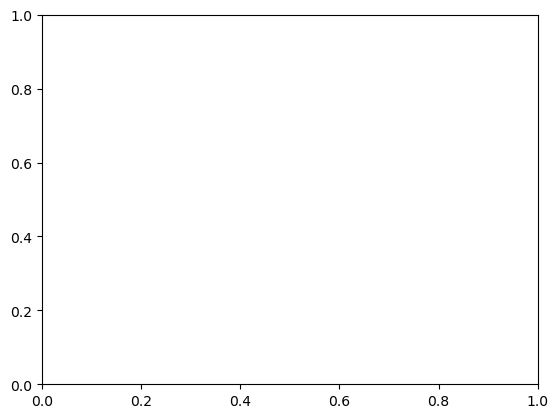

In [23]:
#Plooting chosen dataset
var='anomaly-hd40'
ssp='ssp245'
period='2020-2039'
gcm='median'

dataset=get_cckp_file_name(var,ssp,period,gcm,data_folder=data_folder)
plot_data=read_cckp_ncdata(dataset)
data=rioxarray.open_rasterio(plot_data)#
varname='_'.join((var,period,ssp,gcm))

fig, ax = plt.subplots()
data_clip = data.rio.clip(study_area.geometry, study_area.crs, drop=True)

xlim = ([study_area.total_bounds[0]-0.5,  study_area.total_bounds[2]+0.5])
ylim = ([study_area.total_bounds[1]-0.5,  study_area.total_bounds[3]+0.5])

data_clip=data_clip.where(data_clip != 1e+20)
data_clip.plot(ax=ax,cmap='Blues', xlim=(xlim),ylim=(ylim))
projects_buf.plot(ax=ax,edgecolor="red", facecolor="none") 

study_area.plot(ax=ax, edgecolor="black", facecolor="none")
title='Chosen climate scenario: \n'+var+'_ '+ssp+'_ '+period+'_ '+gcm
ax.set_title(title)

data.close() 
data_clip.close()

<a id='wind'></a>
## Wind Speed - WORK IN PROGRESS

Daily wind speed, historical and projected.

Data source : https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=form

<a id='tsunami'></a>
[Home](#beginning_CRVA)
## Tsunami  - WORK IN PROGRESS: SERVER SIZE ( also, zoom to specific location to see anything) 

"This dataset includes an estimation of the annual physical exposure to tsunamis. It is based on three sources: 1) a comprehensive list of reports and scientific papers compiled and utilized in producing tsunami hazard maps as well as finding return periods of future events; 2) applying numerical tsunami models and zooming on selected areas; and 3) a population grid for the year 2010 (provided by LandScanTM Global Population Database, Oak Ridge National Laboratory, Oak Ridge, USA). The unit of reference is the expected average annual population (2010 as the year of reference) exposed (inhabitants)."

This product was designed by the International Centre for Geohazards (NGI) for the Global Assessment Report on Risk Reduction (GAR). The dataset was was modelled using global data.

Credit: GIS processing International Centre for Geohazards (NGI).

<a id='landslides'></a>
[Home](#beginning_CRVA)
## Landslides: WORKING PROGRESS - SERVER SPACE. 

source: https://datacatalog.worldbank.org/search/dataset/0037584 (Global Landslide Hazard Map, The World Bank)

### Description of LS_TH : 
The Global Landslide Hazard Map presents a qualitative representation of global landslide hazard at a global scale. It is the combination of the The Global Landslide Hazard Map: Median Annual Rainfall-Triggered Landslide Hazard (1980-2018) and The Global Landslide Hazard Map: Earthquake-Triggered Landslide Hazard which has then been simplified to four rank categories, ranging from Very low to High landslide hazard, based on the existing system used by ThinkHazard! (www.thinkhazard.org)

### Description of LS_RF_Median_1980-2018 :
The Global Rainfall-Triggered Landslide Hazard Map presents a quantitative representation of landslide hazard. This component is the median annual rainfall-triggered landslide hazard assessment for the period 1980 – 2018. Raster values represent the modelled average annual frequency of significant rainfall-triggered landslides per sq. km.

In [30]:

#Landslides data paths
landslidesTH_path=os.path.join(data_folder,'landslides/wb_GlLandslHazard/ls_th/LS_TH.tif') ## Global landslide hazard map (TH ranks --> Think hazard ranks)
landslidesRFmean_path=os.path.join(data_folder,'landslides/wb_GlLandslHazard/ls_rf/ls_rf_mean_1980-2018.tif') 
landslidesRFmedian_path=os.path.join(data_folder,'landslides/wb_GlLandslHazard/ls_rf/ls_rf_median_1980-2018.tif') 

#spatial stats
projects_comb['landslides_THmax']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=landslidesTH_path, 
                                                            all_touched=True, stats='max'))
projects_comb['landslidesRF_medianMax']=pd.DataFrame(zonal_stats(vectors=projects_buf, raster=landslidesRFmean_path, 
                                                          all_touched=True, stats='max'))
#show table
projects_comb[[project_id,'landslides_THmax','landslidesRF_medianMax']].head()
print(projects_comb)#['Name','earthquakes_pga_250_yrp.tif','landslides_THmax','landslidesRF_medianMax'])
projects_comb.to_excel('project_comb.xlsx') 

             Name  Type    Munici         lon       lat  \
0           Beloi    TS    Atauro  125.608144 -8.218598   
1         Maliana    TS  Bobonaro  125.204245 -8.923932   
2        Lospalos    TS    Lautem  127.023897 -8.514058   
3        Viqueque    TS  Viqueque  126.359111 -8.873380   
4           Cassa    NL    Ainaro  125.525253 -9.088477   
5         Vemasse    NL    Baucau  126.248182 -8.504763   
6        Metinaro  HCRW      Dili  125.753206 -8.526265   
7    VillaMaumeta    TS   Atauaro  125.607151 -8.259500   
8   PanteMacassar    TS   Oecusse  124.351706 -9.202353   
9           Cassa  HCRW    Ainaro  125.525253 -9.088477   
10        Vemasse  HCRW    Baucau  126.248182 -8.504763   
11          Tibar    EL      Dili  125.497125 -8.577132   

                      geometry  earthquakes_pga_250_yrp.tif  landslides_THmax  \
0   POINT (125.60814 -8.21860)                   240.346115               4.0   
1   POINT (125.20425 -8.92393)                   129.817596           

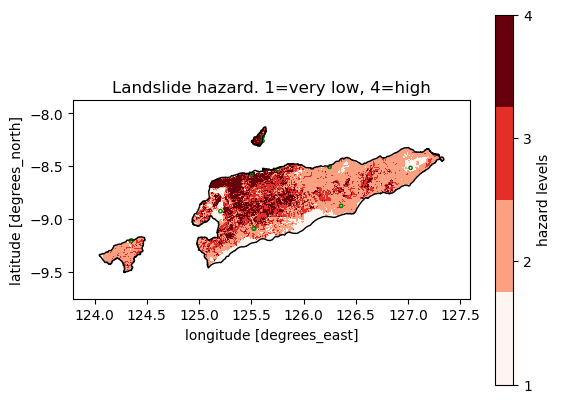

In [28]:
xlim = ([study_area.total_bounds[0]-0.25,  study_area.total_bounds[2]+0.25])
ylim = ([study_area.total_bounds[1]-0.25,  study_area.total_bounds[3]+0.25])

#plot landslides TH
fig, ax = plt.subplots()
landslides_th = rioxarray.open_rasterio(landslidesTH_path) 

landslides_thclip = landslides_th.rio.clip(study_area.geometry, study_area.crs, drop=True)
landslides_th.close()
landslides_thclip=landslides_thclip.where(landslides_thclip != 255)
landslides_thclip.plot(ax=ax, cmap=plt.cm.get_cmap('Reds',4),cbar_kwargs={'label':'hazard levels','ticks':[1,2,3,4]},xlim=(xlim),ylim=(ylim))
points=projects_buf.plot(ax=ax,edgecolor='green',facecolor='none') 
study_area.plot(ax=ax,edgecolor="black", facecolor="none")
ax.set_title('Landslide hazard. 1=very low, 4=high')
#close
landslides_thclip.close()
fig.savefig('landslides_timor.svg', bbox_inches='tight')


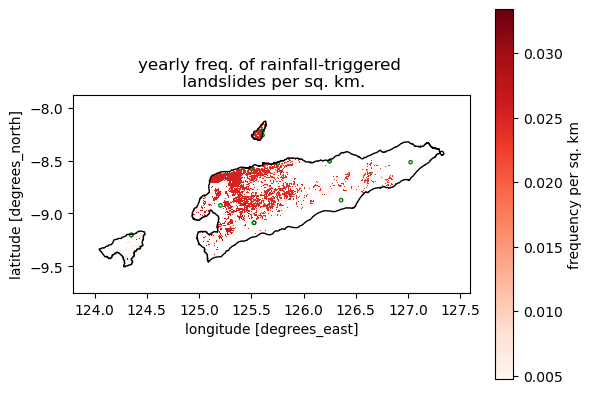

In [29]:

#plot landslides RF 
fig, ax = plt.subplots()
landslides_rf = rioxarray.open_rasterio(landslidesRFmedian_path) 

landslides_rfclip = landslides_rf.rio.clip(study_area.geometry, study_area.crs, drop=True)
landslides_rfclip=landslides_rfclip.where(landslides_rfclip != 0)
landslides_rfclip.plot(ax=ax,vmin=landslides_rfclip.min(),vmax=landslides_rfclip.max(), cmap='Reds',cbar_kwargs={'label':'frequency per sq. km'},xlim=(xlim),ylim=(ylim))
#points=projects.plot(ax=ax,color='black') 
projects_buf.plot(ax=ax,edgecolor="green", facecolor="none") 
study_area.plot(ax=ax,edgecolor="black", facecolor="none")
ax.set_title('yearly freq. of rainfall-triggered \n landslides per sq. km.')

landslides_rfclip.close()
landslides_rf.close()

<a id='relative_sea_level_rise'></a>
[Home](#beginning_CRVA)
## Relative sea level rise - WORKING PROGRESS:  try read nc file in python

<a id='water_availability'></a>
[Home](#beginning_CRVA)
## Water availability  - WORKING PROGRESS
Represented with water stress

Did not find historical data, look into world bank

Source for projections from 2020 to 2050 : https://www.wri.org/data/aqueduct-water-stress-projections-data
Informations about how the shp is designed located here : data_folder, Water_Availability_WaterStress\aqueduct_projections_20150309_shp\aqueduct_projections_schematic_20140615 (excel sheet)

<a id='floods'></a>
[Home](#beginning_CRVA)
## Floods - Hydrosphere - WORKING PROGRESS - to large for server run

####  Fluvial
Sources:
1) JRC Flood Hazard Map, http://data.europa.eu/89h/jrc-floods-floodmapgl_rp100y-tif : The map depicts flood prone areas at global scale for flood events with 100-year return period. Resolution is 30 arcseconds (approx. 1km). Cell values indicate water depth (in m). The map can be used to assess flood exposure and risk of population and assets. NOTE: this dataset is based on JRC elaborations and is not an official flood hazard map (for details and limitations please refer to related publications).
2) Dataset of tropical cyclone Idai and subsequent flood disaster in Southern Africa (March 2019). National Tibetan Plateau Data Center, https://data.tpdc.ac.cn/en/data/8d836d13-a8e6-492b-9324-00fbfce40619/ 



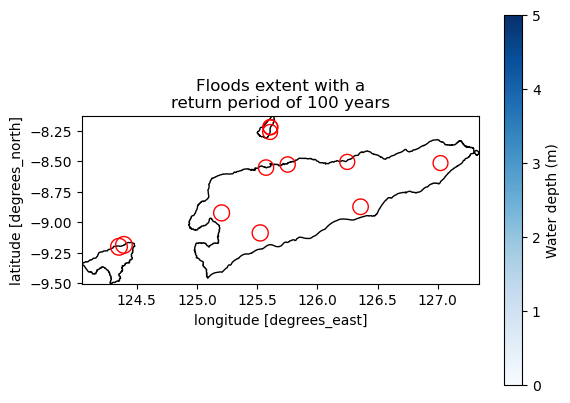

In [51]:
# save the path for the image presenting the floods which have a return period of a 100 year
flood_path=os.path.join(data_folder,'floodMapGL_rp100y/floodMapGL_rp100y.tif')

buffer_flood=1000#meters # pas sure : sert a avoir les 
if buffer_flood != 0:
    projects_bufFlood=projects.to_crs(mCRS)  #project to crs with metric units to get buffer in meters
    projects_bufFlood['geometry']=projects.to_crs(mCRS).buffer(buffer_flood) #assign the buffer as the new geometry - 
    projects_bufFlood=projects_bufFlood.to_crs(bCRS)#project back to orginal crs

projects['floods100yr_max']=pd.DataFrame(zonal_stats(vectors=projects_bufFlood, raster=flood_path, 
                                                            all_touched=True, stats='max'))
#plot
fig, ax = plt.subplots()

floods = rioxarray.open_rasterio(flood_path)
floods_clip = floods.rio.clip(study_area.geometry, study_area.crs, drop=True)
floods.close()
nodata = rasterio.open(flood_path).nodata
floods_clip=floods_clip.where(floods_clip != nodata) 


floods_clip.plot(ax=ax,vmax=5,cmap='Blues',cbar_kwargs={'label':'Water depth (m)'},xlim=(xlim),ylim=(ylim))
#projects.plot(ax=ax,color='Black') # mapping the projects located in the study area
study_area.plot(ax=ax,edgecolor='black',facecolor='none')
projects_buf.plot(ax=ax,edgecolor="red", facecolor="none") 
ax.set_title('Floods extent with a\nreturn period of 100 years') # set a title to the image

#close
floods_clip.close()


<a id='coastal_floods'></a>
#### Coastal 
Source: WRI Aqueduct database - see https://github.com/wri/Aqueduct40/blob/master/data_dictionary_water-risk-atlas.md 

<a id='climate_change_info_for_each_project_in_study_area'></a>
# Climate change information concerning the projects in the study area

Display climate change information concerning the project you are looking into.

[Home](#beginning_CRVA)

In [ ]:
# selection of projects in the study area
#RAPY: not useful since study area is just for plotting purposes, projects should be only the relevant ones already
#projects_of_interest=projects[projects.within(study_area)]

# selection of the information to display
list_of_names=['Name','cyclone_risk']

# display selected climate change information of the projects in the study area
projects_of_interest_filtered = projects[list_of_names]
projects_of_interest_filtered


# Export
Exports the calculated climate variables to a csv file

[Home](#beginning_CRVA)

In [ ]:
projects.T.to_csv('outputs/projects_climate_risks.csv')